# Milestone 4: Analysis and Visualisation 

In [2]:
# Preamble - imports 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sbn 
# from scipy.stats import ks_2samp # miniconda issues couldn't create/activate environment or install scipy. 

In [3]:
# finance_df = pd.read_csv("df_after_Task_6.csv") # All should be cleaned now, dates parsed, etc. 
# type(finance_df) # confirming it's a pd.df :)  
# I've commented out the df above since it got rid of all my useful columns- I will use the data 'cleaned' up to but not including the removal of highly correlated columns instead. 
finance_df = pd.read_csv("df_end_of_Task_5.csv")
finance_df['issue_date'] = pd.to_datetime(finance_df['issue_date']) # while we're at it. 

**Aside:** Upon trying to find suitable columns to 'summarise currently what percentage of the loans are recovered against hte investor funding and the total amount funded,' I realised that data cleaning task number 6 removed all the potentially appropriate columns for that task, namely: 
- **out_prncp**: Remaining outstanding principal for total amount funded
- **out_prncp_inv**: Remaining outstanding principal for portion of total amount funded by investors
- **total_payment**: Payments received to date for total amount funded

I am shocked by the pedagogical blundering that would lead to such an oversight- students don't know where they're going or what sort of analysis will be asked of them, so they don't know how to properly clean the data without utterly destroying its utility, and the casually wirtten data 'cleaning' prompts encourage a cavalier attitude about maintaining data. 

This is why I'm importing the csv from the end of task 5 instead of task 6. 

In [ ]:
# print(finance_df.dtypes) # plopped into loan_data_dict.md for further reference. 

## Task 1: Current state of loans 
1. Summarise currently what percentage of the loans are recovered against the investor funding and the total amount funded. 
2. Visualise the results of the above. 
3. Visualise what percentage of the total amount would be recovered up to 6 months in the future. 

For the first prompt, I'll use the following columns: 
- **out_prncp_inv**: Remaining outstanding principal for portion of total amount funded by investors

In [ ]:
out_prncp_inv = finance_df["out_prncp_inv"]

#out_prncp_inv.head(20)


In [11]:
print(finance_df.shape, out_prncp_inv.size)

(54210, 41) 54210


In [4]:
out_prncp_inv.nlargest(10)

3219    32399.94
1859    31973.38
666     31063.10
2845    31038.00
1763    30981.57
1415    30981.55
1577    30933.50
3783    30933.50
1908    30872.20
21      30782.74
Name: out_prncp_inv, dtype: float64

In [5]:
out_prncp_inv.nsmallest(10)

2     0.0
3     0.0
6     0.0
7     0.0
25    0.0
38    0.0
40    0.0
42    0.0
43    0.0
46    0.0
Name: out_prncp_inv, dtype: float64

In [6]:

out_prncp_inv.mean()

2752.9240243497507

In [7]:
out_prncp_inv.median()

0.0

What the stats above tell us is that 50% of loans are fully paid off (The median outstanding is 0.), and out_prncp_inv is measured most likely in pounds or dollars, not as a percentage. (Just checking for quick wins. ;)

In [8]:
(out_prncp_inv==0).sum()

33946

From the above I can see there are 33946 zeros (i.e. no outstanding debt, i.e. fully repaid loans) out of 54210, so 62.62% of loans are fully repaid. Task 1's first prompt asks us to summarise what percentage of loans are recovered against the investor funding and total amount funded. The 'against' portions of that question are bit confusing, but I can say 62% of loans have been recovered; I'll check that statement using the recoveries column, and visualise, as requested in prompt two. 

To recap from loan_data_dict.md: 
**recoveries**: post charge off gross recovery

If they actually are asking what percentage of **money loaned* is recovered, that is a different story... 

In [12]:
recoveries = finance_df["recoveries"]
print(recoveries.size, recoveries.nlargest(10), recoveries.nsmallest(10))

54210 29116    16188.880000
36980    15236.310000
37278    14165.110000
37297    14004.010000
49268    14000.160000
29414    13900.000000
8428     13832.920000
49140    13777.020000
44938    13425.987971
37594    12961.320000
Name: recoveries, dtype: float64 0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
9    0.0
Name: recoveries, dtype: float64 89.52323483605744 0.0


In [13]:
recoveries.mean()

89.52323483605744

In [14]:
recoveries.median()

0.0

In [15]:
# Noticed mean and median different, suggests skew... 

recoveries.skew() # 11 - yep, highly skewed. 

11.206563566763865

In [16]:
#So how many recoveries are at 0? 
(recoveries==0).sum()

50558

As you can see from the above, a whopping 50558/54210 = 93.26% of recoveries are at 0; this is neither equal to, nor the complement of, the 62% of loans have no principal left to pay (out_prncp_inv, if I understand that correctly). I don't think it's entirely clear from the data description what the real difference is between these two measures, but whatever. I've now provided two percentages that could describe how many of the loans "are recovered." 

Of interest is the "against the investor" portion of the prompt--- my question is, do you want me to identify the percentage of recoveries **per member_id**?? That's the closest to a variable that indicates a human being involved in the transaction; however, that is, according to the loan_data_dict, an identifier of the borrower, not the investor (who would be lending). So that interpretation may be a stretch. 

- **id**: unique id of the loan
- **member_id**: id of the member to took out the loan

Furthermore, this seems like a needlessly arguous (because it's unlike to lead to meaningful insights) task unless there are 20 or fewer investors. So I'll check that before I do anything crazy: 

In [17]:
member_id = finance_df["member_id"]
member_id.nunique()

54210

54210. Since there are as many unique member_id's as there are loans, it would be pointless to report on percentages with respect to the member_id - they'd all be 0% or 100% individually. 

The other part of that prompt was to look at percentage of recovered loans "against total amount funded." 
Perhaps a simple way to consider this would be to look at a binary status of recovery, much as we've been interpreting the 0's in 'recoveries' and 'out_prncp_inv.' I'll identify the mean total loan_amount for each status, 'recovered,' (0), and 'unrecovered' (>0), and see if there's an interesting relationship (or just coincidental difference in means) using box plots and hypothesis testing. 

**loan_amount**: amount of loan the applicant received

In [18]:
#Since the description of "recoveries" makes no sense to me, I'm going to consider the out_prncp_inv measure for understanding how many loans are recovered: 
finance_df_copy = finance_df.copy()

cleared_loans = finance_df_copy[finance_df_copy['out_prncp_inv'] == 0]
ongoing_loans = finance_df_copy[finance_df_copy['out_prncp_inv'] > 0]

In [19]:
cleared_loans["loan_amount"].mean()

12368.03452542273

In [20]:
ongoing_loans["loan_amount"].mean()

14940.470785629688

From the above we can see the average loan amount is higher in the group of still-unpaid loans. (Makes sense. Can't pay it off faster just because you want to, and there's more distance to run.)

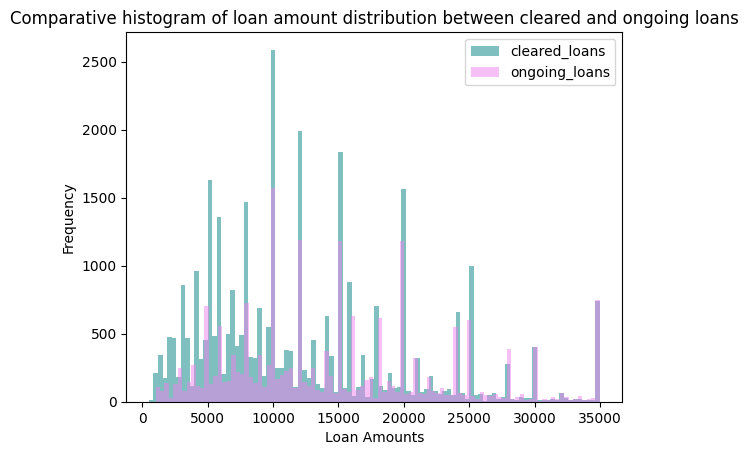

In [22]:
# The hypothesis test most suited depends on the distribution of the two datasets being compared. 
plt.hist(cleared_loans['loan_amount'], bins=100,alpha=0.5,label='cleared_loans', color='teal') 
plt.hist(ongoing_loans['loan_amount'], bins=100,alpha=0.5,label='ongoing_loans', color = 'violet')
plt.xlabel("Loan Amounts")
plt.ylabel("Frequency")
plt.title("Comparative histogram of loan amount distribution between cleared and ongoing loans")
plt.legend()
plt.show()

In [ ]:
#Now do a hypothesis test with Kolmogorov-Smirnov test: 
"""
statistic, p_value = ks_2samp(ongoing_loans["loan_amount"], cleared_loans["loan_amount"])

alpha = 0.05 # Sig lvl 
if p_value < alpha: 
    print(f"Since {p_value} is less than 0.05, we have enough evidence to reject the null hypothesis: the loan amounts of the cleared loans are markedly different from the loan amounts of the ongoing loans.")
else: 
    print(f"Since {p_value} is greater than 0.05, there isn't enough evidence to reject the null. loan amounts from both samples may come from the same population.")
    """
# miniconda issues couldn't create/activate environment or install scipy. 

1. Summarise currently what percentage of the loans are recovered against the investor funding and the total amount funded. 
2. Visualise the results of the above. 
3. Visualise what percentage of the total amount would be recovered up to 6 months in the future. 

Frankly I'm miles behind so this is no longer about doing the job well-- just getting it done. 
In which case, consider 1 and 2 done, on to prompt number 3--- what does this mean? 
I guess I'll need to model out_prncp_inv against something time related... let's just pick something: last_payment_date. 

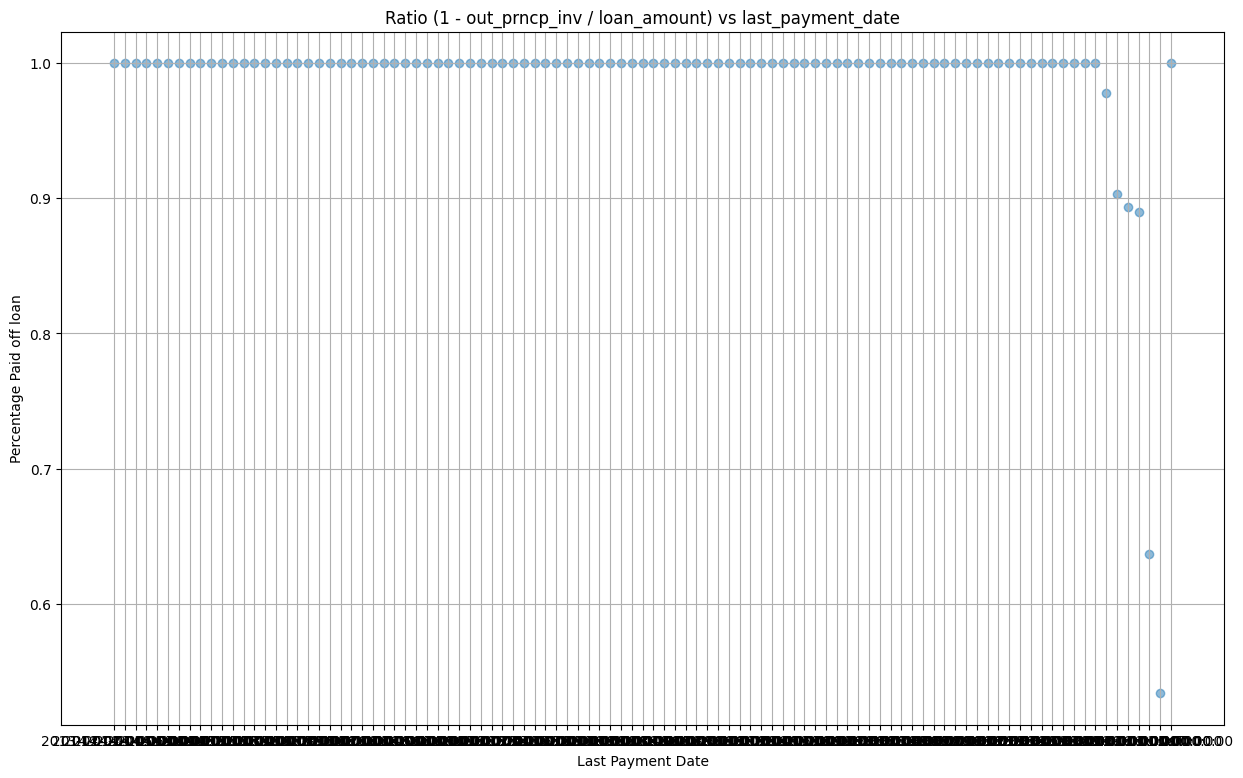

In [7]:

# Calculate the ratio 1 - out_prncp_inv / loan_amount
finance_df['ratio'] = 1 - finance_df['out_prncp_inv'] / finance_df['loan_amount']

# Group by 'last_payment_date' and calculate mean of the ratio
grouped_df = finance_df.groupby('last_payment_date')['ratio'].mean().reset_index()

# Plotting parameters
x_column = 'last_payment_date'
y_column = 'ratio'
title = 'Ratio (1 - out_prncp_inv / loan_amount) vs last_payment_date'
x_label = 'Last Payment Date'
y_label = 'Percentage Paid off loan'

# Create scatterplot
plt.figure(figsize=(15, 9))
plt.scatter(grouped_df[x_column], grouped_df[y_column], alpha=0.5)
plt.title(title)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.grid(True)
plt.show()

Extrapolating with a line of best fit seems unfair, since the trend is essentially "the most recent payments are attached to a hodge podge of loans and before that, it's a monolith." To visualise, I would say, imagine the last six months, slid forward. Especially since new loans will no doubt be created in that time.  

# Milestone 4: Task 2: Calculating loss 
Calculate the percentage of "Charged Off" (in the loan_status column) loans "historically" (what do you mean here? All data is from the past.) and the total amount that was paid towards these loans before being charged off. 


In [14]:
# First, What percentage of loans were charged off? 

finance_df['loan_status'].count() # 54210
finance_df['loan_status'].value_counts() # Reveals Charged Off has 5561 entries



loan_status
Fully Paid                                             27037
Current                                                19263
Charged Off                                             5561
Does not meet the credit policy. Status:Fully Paid       982
Late (31-120 days)                                       580
Does not meet the credit policy. Status:Charged Off      364
In Grace Period                                          265
Late (16-30 days)                                        106
Default                                                   52
Name: count, dtype: int64

In [15]:
5561/54210 # = 10.3% 

0.10258254934513927

About 10 percent of loans have been Charged Off. Now to work out the total amount that was paid towards these loans before they were charged off. 
Sounds like a job for **total_payment**: Payments received to date for total amount funded.

In [16]:
finance_df.loc[finance_df['loan_status'] == 'Charged Off', 'total_payment'].sum()

37152531.31770619

So in total 37,152,531.32 was paid towards these loans before they were 'Charged Off.' 

### Task 3: Calculating Projected Loss 
Prompt 1: Calculate the projected loss of the loans marked as Charged Off.
    - By this I'll assume you mean the total above subtracted from all 'Charged Off' loans' original worth. 
2: Calculate the loss in revenue these loans would have generated for the company if they had finished their term. 
    - By this I'll assume you mean subtract the above from the sum of all 'Charged Off' loans' final worth. 
3: Visualise the loss projected over the remaining term of these loans.
    - And here I guess you want a graph that shows the sum of the above but for each individual loan, versus 'issue_date' + 'term.' 

Probably simplest way to do this is use boolean indexing at the start to create a sub-df of just those key features, including considering only 'Charged Off' loans. 

In [27]:
# Create sub-dataframe 

charged_off_df = finance_df.loc[finance_df['loan_status'] == 'Charged Off'].copy()

charged_off_df.shape

(5561, 41)

In [22]:
# Original Worth is probably represented by 'loan_amount' 

charged_off_df['loan_amount'].sum() # 76123800

76123800

In [24]:
# So projected loss is: 
76123800 - 37152531.32 # = 38,971,268.68

38971268.68

There's prompt 1 done. Prompt 2's about the loan's *potential* value, were it paid off over time. So we need to use the formula using the following two parameters for each row... 
- **term**: The number of monthly payments for the loan
- **int_rate**: Interest rate on the loan
For my own sanity I'll assume your interest rates are monthly as well. 

So A = P x (1+ i/100)^t 

Or, for a single loan, 

A = loan_amount * (1 + int_rate/100) ** term 

In [29]:
charged_off_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 5561 entries, 7 to 54177
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  5561 non-null   int64  
 1   id                          5561 non-null   int64  
 2   member_id                   5561 non-null   int64  
 3   loan_amount                 5561 non-null   int64  
 4   funded_amount               5561 non-null   float64
 5   funded_amount_inv           5561 non-null   float64
 6   term_length_in_months       5561 non-null   float64
 7   int_rate                    5561 non-null   float64
 8   instalment                  5561 non-null   float64
 9   grade                       5561 non-null   object 
 10  sub_grade                   5561 non-null   object 
 11  years_of_employment         5561 non-null   float64
 12  home_ownership              5561 non-null   object 
 13  annual_inc                  5561 non-

In [5]:
# Calculate A for every row
charged_off_df['A'] = charged_off_df['loan_amount'] * (1 + charged_off_df['int_rate'] / 100) ** charged_off_df['term_length_in_months']

# Find the sum of all values of A
total_A = charged_off_df['A'].sum()

print("Total sum of A:", total_A)


Total sum of A: 3660676245975.542


So all the A's add up to 3660676245975.542! Answering prompt 2: 

In [31]:
3660676245975.542 - 37152531.32

3660639093444.222

Loss of possible earnings, had the loans been paid in full to term: 
3660639093444.222
On to prompt 3: 

I think this will be along the lines of an itemised version of the above differences, plotted against issue_date + term. 

In [7]:
"""
date = 2021-01-01 00:00:00 

  Cell In[43], line 1
    date = 2021-01-01 00:00:00
                ^
SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal intege

term = 36.0 

date + term
"""

# THe code below was a sample of the date and term length formats I'm workign with, so see waht would happen. Got an error about the date format. Will need to parse the issue_date into year-month. 

# charged_off_df['issue_date'].dtypes # oh my this never got through the cleaning process. 

charged_off_df['issue_date'] = pd.to_datetime(charged_off_df['issue_date'])


In [49]:
charged_off_df['issue_date'].dtype

dtype('<M8[ns]')

In order to add date with float, I'm applying a modifier suggested by ChatGPT, with the caveat that it uses an estimate of 30 days per month. 

In [8]:
charged_off_df['end_date'] = charged_off_df.apply(lambda row: row['issue_date'] + pd.DateOffset(months=row['term_length_in_months']), axis=1)


Finishing 3: Visualise the loss projected over the remaining term of these loans.

    - Aim: graph that shows A + B - C, versus 'end_date'
    - A is already worked out:  charged_off_df['A'] = charged_off_df['loan_amount'] * (1 + charged_off_df['int_rate'] / 100) ** charged_off_df['term_length_in_months'] 
    - B will be worked out: charged_off_df['loan_amount'] *in adding this I realise it's redundant.* 
    - C will be worked out: charged_off_df['total_payment']
    
Well that all simplifies things. 

In [9]:
charged_off_df['loss'] = charged_off_df['A'] - charged_off_df['total_payment']

Now I just need to plot 'end_date' versus 'loss'. 

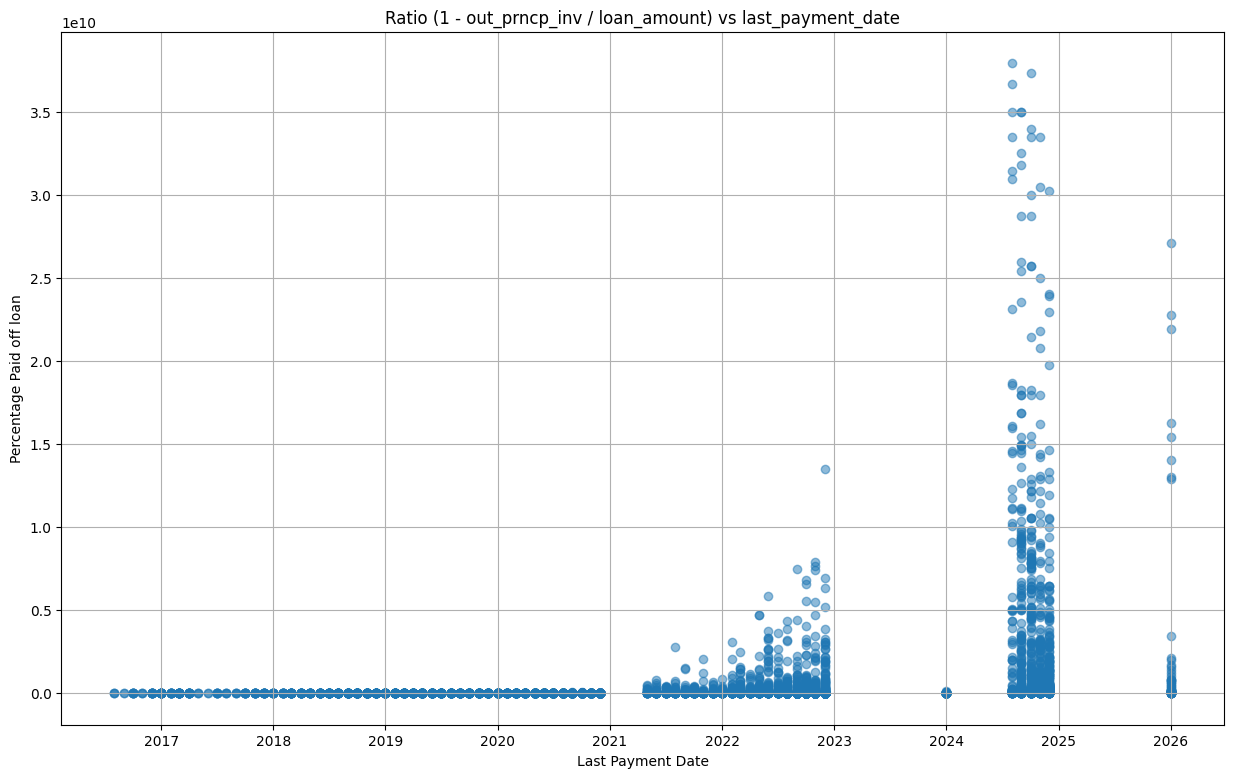

In [11]:
# Plotting parameters
x_column = 'end_date'
y_column = 'loss'
title = 'Ratio (1 - out_prncp_inv / loan_amount) vs last_payment_date'
x_label = 'Last Payment Date'
y_label = 'Percentage Paid off loan'

# Create scatterplot
plt.figure(figsize=(15, 9))
plt.scatter(charged_off_df[x_column], charged_off_df[y_column], alpha=0.5)
plt.title(title)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.grid(True)
plt.show()

Stands to reason you stand to lose more from loans that are due later. You had more interest yet to suck out of them. 

### Milestone 4: Task 4: Possible loss 

1. Calculate the total amount of customers in the bracket "behind on loan payments." 
2. Calculate how much loss the company would incur IF they were "Charged Off." 
3. What is the projected loss of these loans if the customer were to finish the loans full term? 

In [4]:
finance_df['loan_status'].value_counts()

loan_status
Fully Paid                                             27037
Current                                                19263
Charged Off                                             5561
Does not meet the credit policy. Status:Fully Paid       982
Late (31-120 days)                                       580
Does not meet the credit policy. Status:Charged Off      364
In Grace Period                                          265
Late (16-30 days)                                        106
Default                                                   52
Name: count, dtype: int64

In [13]:
print(106+580)

late_statuses = ['Late (31-120 days)', 'Late (16-30 days)']

late_df = finance_df[finance_df['loan_status'].isin(late_statuses)].copy()

686


Answers:

1. Calculate the total amount of customers in the bracket "behind on loan payments." 
    - It's 686, adding value counts for both categories containing the word 'late.' 
2. Calculate how much loss the company would incur IF these lates were "Charged Off." 
     - See next panel, below. The sum appears to be zero so, wahay. These people have all alread paid off their original loan's values, I guess. 
3. What is the projected loss of these loans if the customer were to finish the loans full term? 
    - £608866792914.8699
    - See the code chunk below, starting "# Calculate A for every row."
    - I noticed and used this measure from loan_data_dict.md this time: **total_payment**: Payments received to date for total amount funded  

In [14]:
# Again assuming 'loan_amount' represents the worth of the loan 

late_df['loan_amount'].sum() # this sums to 10302800

10302800

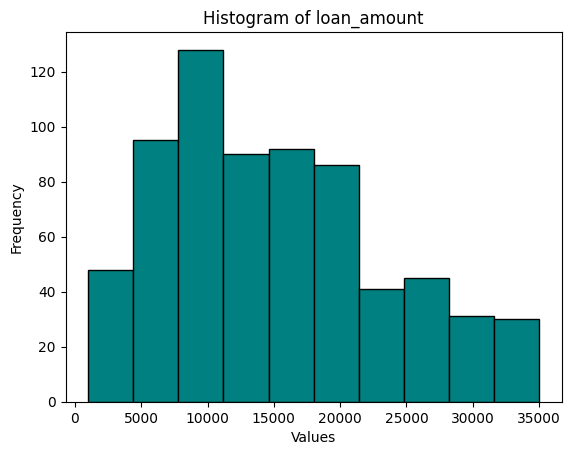

In [15]:
# Out of curiosity, has the distribution of loan_amounts changed visibly when considering only the 'late' status sample? 

column_name = 'loan_amount'

# Plotting histogram
plt.hist(late_df[column_name], bins=10, color='teal', edgecolor='black')

# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of ' + column_name)

# Showing plot
plt.show()



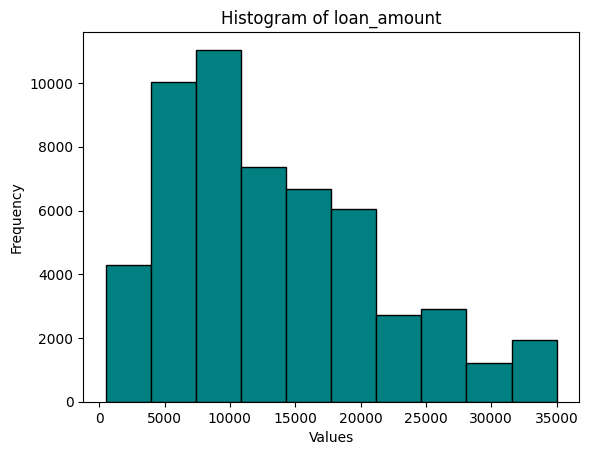

In [16]:
# As you can see, no, the distributions are quite similar. 
plt.hist(finance_df[column_name], bins=10, color='teal', edgecolor='black')

# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of ' + column_name)

# Showing plot
plt.show()


In [17]:
# Calculate A for every row 

late_df['A'] = late_df['loan_amount']*(1 + late_df['int_rate']/100)**late_df['term_length_in_months']

# Find sum of all A 
total_A = late_df['A'].sum()
#print("Total projected value of loans with late status:" total_A)

# Subtract what we've already taken in loan repayments. (I may have forgotten this last time.)
earned_of_lates = late_df['total_payment'].sum()

# Subtract: 
projected_losses_of_lates = total_A - earned_of_lates

print(projected_losses_of_lates)

608866792914.8699


## Task 5: Indicators of Loss 

This prompt is much more vauge and open-ended, so I'll set myself some precise goals to get it done: 

1. Set up a dummy variable of 0 or 1. 1 Will indicate the status 'Charged Off'. 
2. Examine whether 'loan_amount,' 'employment length,' 'grade,' 'purpose', or 'home_ownership' correlate highly with 'Charged Off.' 
3. Investigate whether linear regression with a Binomial Distribution of output would be easily easible in Python-- may be able to distill the five potential indiciators, above, into a model. 
4. Compare distributions (as histograms) of the five potential indicators above (fewer if some low correlations have so suggested) when only in the charged_off_df vs when in the entire population, finance_df. 
5. Selecting the best possible indicators based on the methods above, check the 'Late' loans to see if any may be at risk of turning to 'Charged off.'  

In [28]:
#finance_df['grade'].dtype
#finance_df['grade'].value_counts()

# A little in-place "data cleaning" now that I know how this might be used.
grade_map = {'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F': 2, 'G': 1}

finance_df['grade'] = finance_df['grade'].map(grade_map)
charged_off_df['grade'] = charged_off_df['grade'].map(grade_map)
late_df['grade'] = late_df['grade'].map(grade_map)

In [30]:
finance_df['purpose'].value_counts() # this isn't ordinal data so it's not going to be feasible to use correlation to judge its potential meaningfulness. I'll jump straight to step 4 for this one. 

purpose
debt_consolidation    29582
credit_card           11131
other                  3696
home_improvement       3213
major_purchase         1678
small_business         1310
car                    1022
medical                 631
wedding                 539
moving                  454
house                   354
vacation                320
educational             201
renewable_energy         79
Name: count, dtype: int64

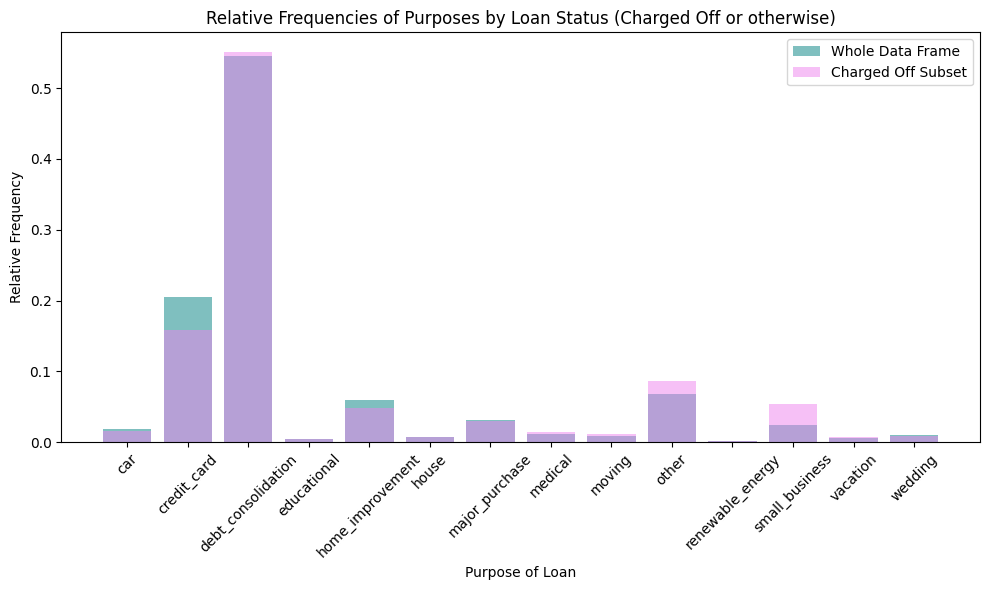

In [31]:
# Calculate relative frequencies for each dataframe
relative_freq_df1 = finance_df['purpose'].value_counts(normalize=True).sort_index()
relative_freq_df2 = charged_off_df['purpose'].value_counts(normalize=True).sort_index()

# Plotting
plt.figure(figsize=(10, 6))

# Plot relative frequencies for df1
plt.bar(relative_freq_df1.index, relative_freq_df1.values, color='teal', alpha=0.5, label='Whole Data Frame')

# Plot relative frequencies for df2
plt.bar(relative_freq_df2.index, relative_freq_df2.values, color='violet', alpha=0.5, label='Charged Off Subset')

# Adding labels and title
plt.xlabel('Purpose of Loan')
plt.ylabel('Relative Frequency')
plt.title('Relative Frequencies of Purposes by Loan Status (Charged Off or otherwise)')
plt.xticks(rotation=45)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

From this we might surmise that if 'credit card' or 'home improvement' is the purpose of the loan, reaching status of 'charged off' is slightly less likely, while if 'other' or 'renewable energy' is the purpose of the loan, reaching thes tatus of 'charged off' is more likely-- in fact, for 'other' purposes it looks to be roughly 20% more likely, and for 'renewable energy' it looks to be roughly twice as likely!. So when 'purpose' column is 'other' or 'renewable energy,' this could indicate the loan is at risk of being charged off. 


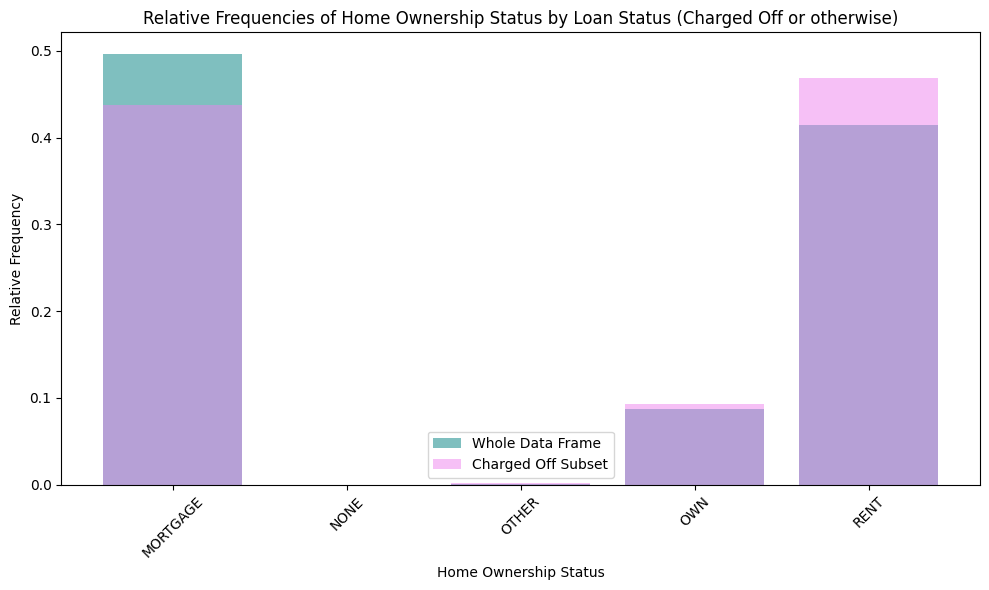

In [33]:
# home ownership is also a non-ordinal status. So I'll do the same for it. 

# Calculate relative frequencies for each dataframe
relative_freq_df1 = finance_df['home_ownership'].value_counts(normalize=True).sort_index()
relative_freq_df2 = charged_off_df['home_ownership'].value_counts(normalize=True).sort_index()

# Plotting
plt.figure(figsize=(10, 6))

# Plot relative frequencies for df1
plt.bar(relative_freq_df1.index, relative_freq_df1.values, color='teal', alpha=0.5, label='Whole Data Frame')

# Plot relative frequencies for df2
plt.bar(relative_freq_df2.index, relative_freq_df2.values, color='violet', alpha=0.5, label='Charged Off Subset')

# Adding labels and title
plt.xlabel('Home Ownership Status')
plt.ylabel('Relative Frequency')
plt.title('Relative Frequencies of Home Ownership Status by Loan Status (Charged Off or otherwise)')
plt.xticks(rotation=45)
plt.legend()

# Show plot
plt.tight_layout()
plt.show() 

Here we can similarly consider renters about 10% more likely to default/charge off, and those paying mortgages roughly 10% less likely. So the home_ownership status of 'renter' may be an indicator. 

### Revisiting goals: 

1. Set up a dummy variable of 0 or 1. 1 Will indicate the status 'Charged Off'. 
    - Complete, by the first chunk of code, below. 
2. Examine whether 'loan_amount,' 'employment length,' or 'grade' correlate highly with 'Charged Off.' 
    - This isn't suitable for 'purpose' and 'home_ownership'
3. Investigate whether linear regression with a Binomial Distribution of output would be easily easible in Python-- may be able to distill the five potential indiciators, above, into a model. 
4. Compare distributions (as histograms) of the five potential indicators above (fewer if some low correlations have so suggested) when only in the charged_off_df vs when in the entire population, finance_df. 
    - This is done for 'purpose' and 'home_ownership,' with the conclusion to watch out for purpose = 'other' or 'renewable energy,' and for home_ownership = 'RENT.' 
5. Selecting the best possible indicators based on the methods above, check the 'Late' loans to see if any may be at risk of turning to 'Charged off.'  

In [34]:
# Create dictionary to map loan statuses
loan_status_map = {'Charged Off': 1}

# Create loan_status_dummy column using map function
finance_df['loan_status_dummy'] = finance_df['loan_status'].map(loan_status_map)

# Fill NaN values with 0 (for loan statuses not in the dictionary)
finance_df['loan_status_dummy'].fillna(0, inplace=True)

In [38]:
finance_df['loan_status_dummy'].value_counts()


loan_status_dummy
0.0    48649
1.0     5561
Name: count, dtype: int64

In [40]:
finance_df['grade'].head() # crap. I somehow broke the grade column. I'll try again with sub-grade. 

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: grade, dtype: float64

In [42]:
finance_df['sub_grade'].value_counts().sort_index()

sub_grade
A1    1151
A2    1481
A3    1752
A4    2645
A5    2788
B1    2929
B2    3240
B3    3641
B4    3542
B5    3016
C1    3018
C2    2962
C3    2793
C4    2511
C5    2313
D1    1838
D2    1808
D3    1645
D4    1509
D5    1353
E1     989
E2     985
E3     816
E4     656
E5     623
F1     486
F2     389
F3     323
F4     285
F5     205
G1     156
G2     132
G3      86
G4      74
G5      70
Name: count, dtype: int64

Since I somehow screwed up the grade column (and replaced it in place, oh foolish me!) I'll use a simpler method to use subgrade as the potential indicator instead. 

In [43]:
# Create dictionary to map subgrades to numerical values
subgrade_mapping = {
    'A1': 35, 'A2': 34, 'A3': 33, 'A4': 32, 'A5': 31,
    'B1': 30, 'B2': 29, 'B3': 28, 'B4': 27, 'B5': 26,
    'C1': 25, 'C2': 24, 'C3': 23, 'C4': 22, 'C5': 21,
    'D1': 20, 'D2': 19, 'D3': 18, 'D4': 17, 'D5': 16,
    'E1': 15, 'E2': 14, 'E3': 13, 'E4': 12, 'E5': 11,
    'F1': 10, 'F2': 9, 'F3': 8, 'F4': 7, 'F5': 6,
    'G1': 5, 'G2': 4, 'G3': 3, 'G4': 2, 'G5': 1
}

# Create new column using map function
finance_df['sub_grade_numeric'] = finance_df['sub_grade'].map(subgrade_mapping)

In [45]:
finance_df['sub_grade_numeric'].value_counts().sort_index() # much better 

sub_grade_numeric
1       70
2       74
3       86
4      132
5      156
6      205
7      285
8      323
9      389
10     486
11     623
12     656
13     816
14     985
15     989
16    1353
17    1509
18    1645
19    1808
20    1838
21    2313
22    2511
23    2793
24    2962
25    3018
26    3016
27    3542
28    3641
29    3240
30    2929
31    2788
32    2645
33    1752
34    1481
35    1151
Name: count, dtype: int64

Now I should be able to calculate the correlation between the three remaining potential indicators (which have been made numerical) and the loan_status_dummy variable. 

In [46]:
finance_df['loan_status_dummy'].corr(finance_df['sub_grade_numeric'])

-0.14824964128871362

In [48]:
finance_df['loan_status_dummy'].corr(finance_df['years_of_employment'])

-0.013758190725352294

In [49]:
finance_df['loan_status_dummy'].corr(finance_df['loan_amount'])

0.015033913927438846

They're all weakly correlated, with the most notable being sub-grade. I bet, if I hadn't destroyed grade, it would have showed stronger chunking. Oh well. As it is, this doesn't seem like a meaningful indicator. I'll take one last look at grades using method 4: 

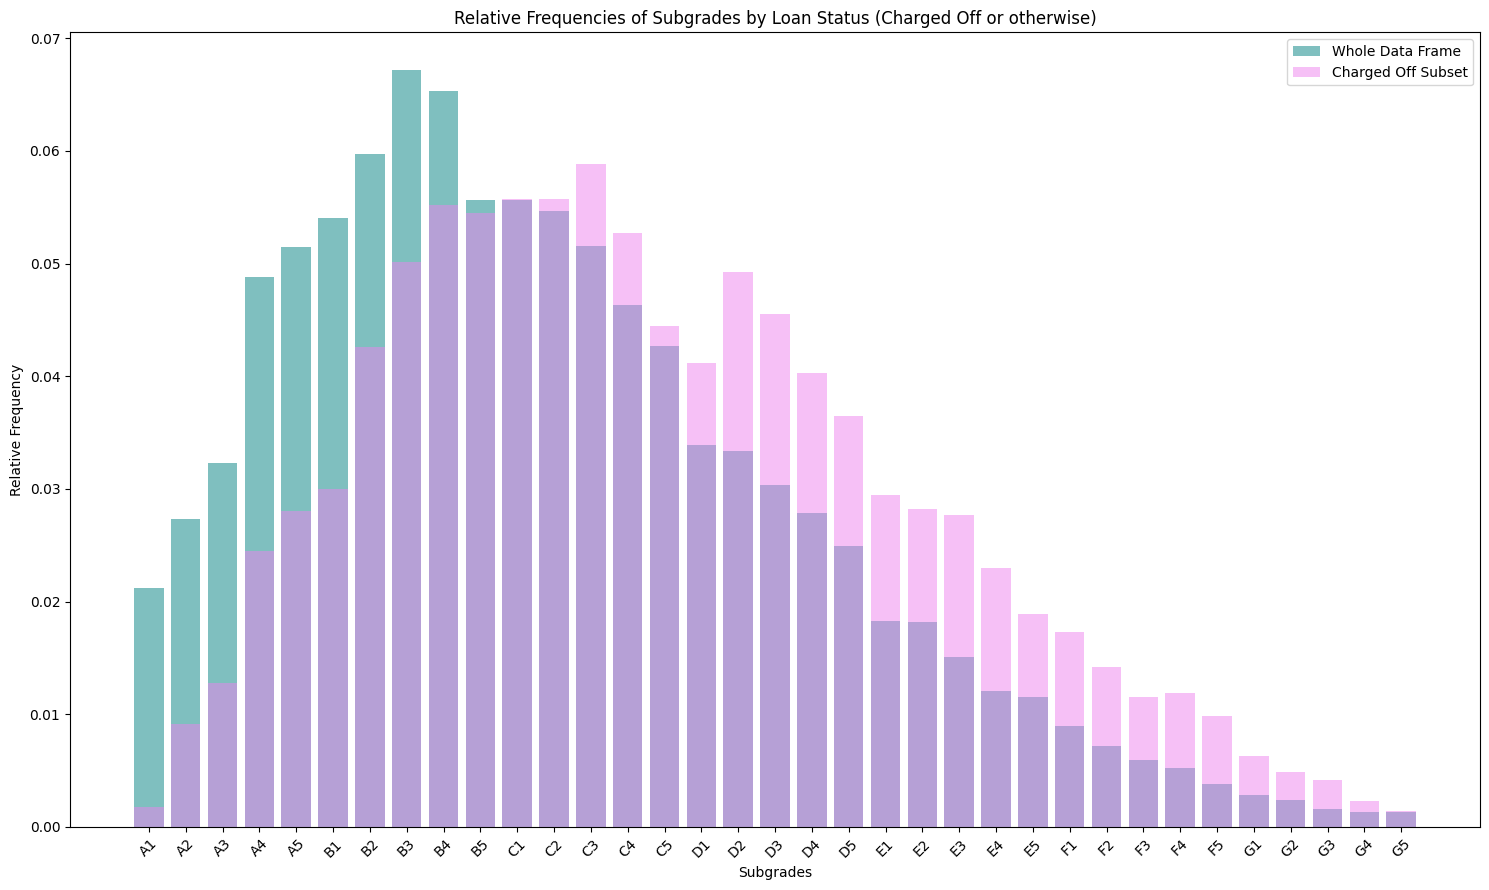

In [50]:
# Calculate relative frequencies for each dataframe
relative_freq_df1 = finance_df['sub_grade'].value_counts(normalize=True).sort_index()
relative_freq_df2 = charged_off_df['sub_grade'].value_counts(normalize=True).sort_index()

# Plotting
plt.figure(figsize=(15, 9))

# Plot relative frequencies for df1
plt.bar(relative_freq_df1.index, relative_freq_df1.values, color='teal', alpha=0.5, label='Whole Data Frame')

# Plot relative frequencies for df2
plt.bar(relative_freq_df2.index, relative_freq_df2.values, color='violet', alpha=0.5, label='Charged Off Subset')

# Adding labels and title
plt.xlabel('Subgrades')
plt.ylabel('Relative Frequency')
plt.title('Relative Frequencies of Subgrades by Loan Status (Charged Off or otherwise)')
plt.xticks(rotation=45)
plt.legend()

# Show plot
plt.tight_layout()
plt.show() 

Ooooh, pretty. These two distributions do appear to be perfect phase shifts of one another. So lower grades (from C2 down) increase the odds of going Charged Out. To identify risky loans, we'll say from grade D down to be conservative, or anything below a B if we're greedy.

## The final task: Assess non-Charged-Out loans for risk using your indicators. 
Based on the line of inquiry and graphics above, I'll check for late loans with: 
- purpose = other or renewable_energy 
- home_ownership = RENT 
- sub_grade lower than a B (i.e. below 25)

In [51]:
late_df['sub_grade_numeric'] = late_df['sub_grade'].map(subgrade_mapping)

In [53]:
# Check conditions and assign points accordingly
late_df['purpose_risk'] = (late_df['purpose'].isin(['other', 'renewable_energy'])).astype(int) # astype(int) means instead of T/F we'll get 1/0, then we can sum risk scores! 
late_df['home_risk'] = (late_df['home_ownership'] == 'RENT').astype(int)
late_df['grade_risk'] = (late_df['sub_grade_numeric'] < 25).astype(int)

# Calculate total risk score
late_df['total_risk_score'] = late_df['purpose_risk'] + late_df['home_risk'] + late_df['grade_risk']

# Filter rows with total risk score greater than 0
filtered_df = late_df[late_df['total_risk_score'] > 0]

# Display table with 'id' as first column and risk columns as last four columns
display_table = filtered_df[['id', 'purpose_risk', 'home_risk', 'grade_risk', 'total_risk_score']]

print(display_table)

             id  purpose_risk  home_risk  grade_risk  total_risk_score
17     38655869             0          0           1                 1
140    38644147             0          1           1                 2
171    38635273             0          1           0                 1
344    38614705             0          1           0                 1
376    38606166             0          1           0                 1
...         ...           ...        ...         ...               ...
43761    644644             0          1           1                 2
44487    624521             0          0           1                 1
45363    601614             0          0           1                 1
45599    595187             0          1           0                 1
46726    560150             0          0           1                 1

[551 rows x 5 columns]


In [55]:
len(display_table)

551

In the table above we've identified 551 at-risk loans. Their risk scores and id's are displayed above. Filtering further: 

In [57]:
filt_deeper = late_df[late_df['total_risk_score']>2]

display2 = filt_deeper[['id', 'purpose_risk', 'home_risk', 'grade_risk', 'total_risk_score']]

len(display2)

28

There are 28 high-risk loans, as follows: 

In [58]:
print(display2)

             id  purpose_risk  home_risk  grade_risk  total_risk_score
2165   38292445             1          1           1                 3
3363   37791387             1          1           1                 3
3640   37722042             1          1           1                 3
3864   37602304             1          1           1                 3
6792    9794911             1          1           1                 3
7501    9695574             1          1           1                 3
7564    9684678             1          1           1                 3
8259    9384568             1          1           1                 3
8532    9237538             1          1           1                 3
10591   9026488             1          1           1                 3
11435   8975588             1          1           1                 3
11760   8971578             1          1           1                 3
13446   8775165             1          1           1                 3
15449 